In [39]:
import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn 
from scipy import sparse
from torch_geometric.utils import add_self_loops, from_scipy_sparse_matrix
import math
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from scipy import sparse, stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [40]:
import sys
import os
import scanpy as sc
import torch
import numpy as np


current_dir = os.getcwd()

src_path = os.path.abspath(os.path.join(current_dir, '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from SpaDiffusion.spatial_vae import Spatial_VAE, VAE_Trainer, setup_seed

In [3]:
from SpaDiffusion.data_process import build_spatial_graph,data_to_tensor
import anndata as ad
import matplotlib.pyplot as plt

In [ ]:

setup_seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


DATA_PATH = "examples/A2R/RNA_VAE/S1_RNA_common.h5ad"
WEIGHT_PATH = "examples/A2R/RNA_VAE/output_refactored/SpatiallyAwareVAE_model_nb_256.pt"


print("Loading data...")
S1_RNA_data = sc.read_h5ad(DATA_PATH)

edge_index = build_spatial_graph(S1_RNA_data, n_neighbors=4,device=DEVICE)
x_tensor= data_to_tensor(S1_RNA_data, DEVICE)



Using device: cuda
Loading data...


Building model...
Loading weights from: /mnt/d/SpaDiffusion/examples/A2R/RNA_VAE/output_refactored/SpatiallyAwareVAE_model_nb_256.pt
Latent shape: (1949, 256)


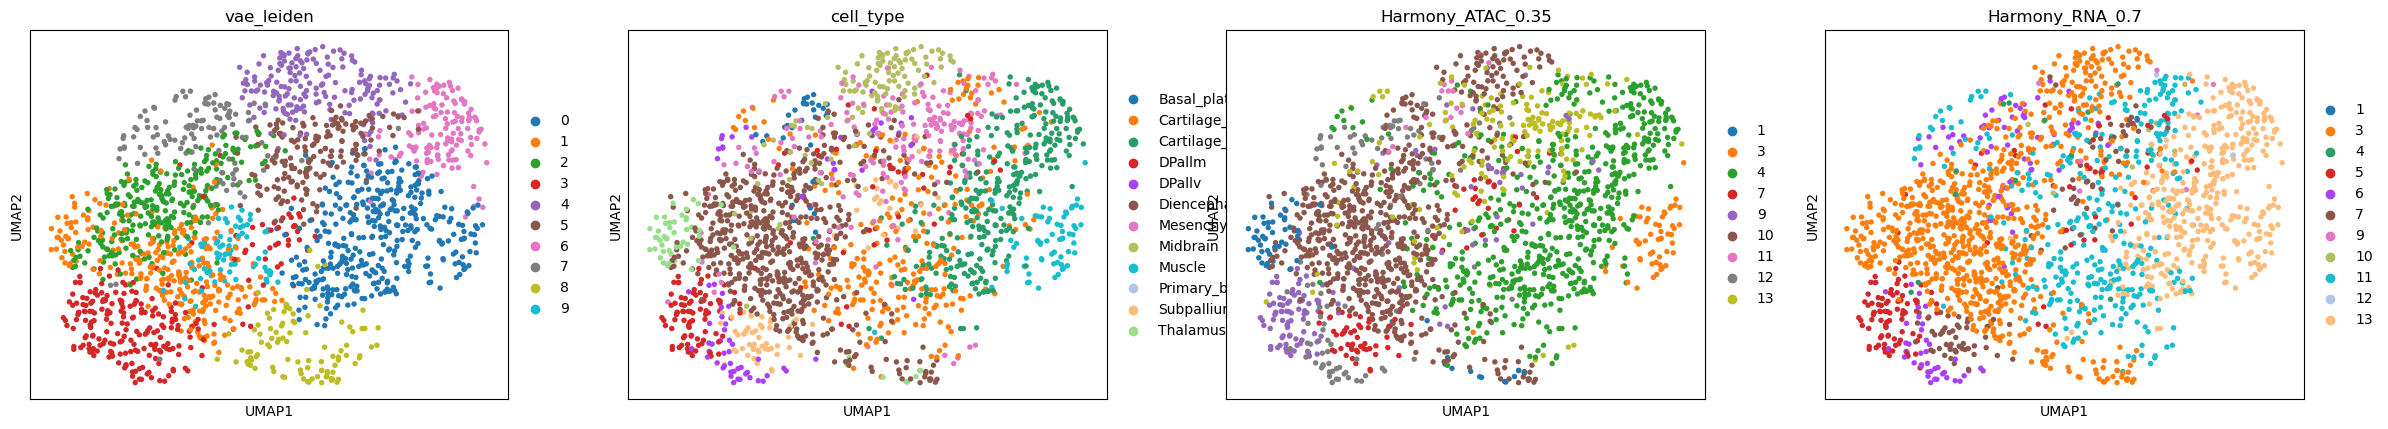

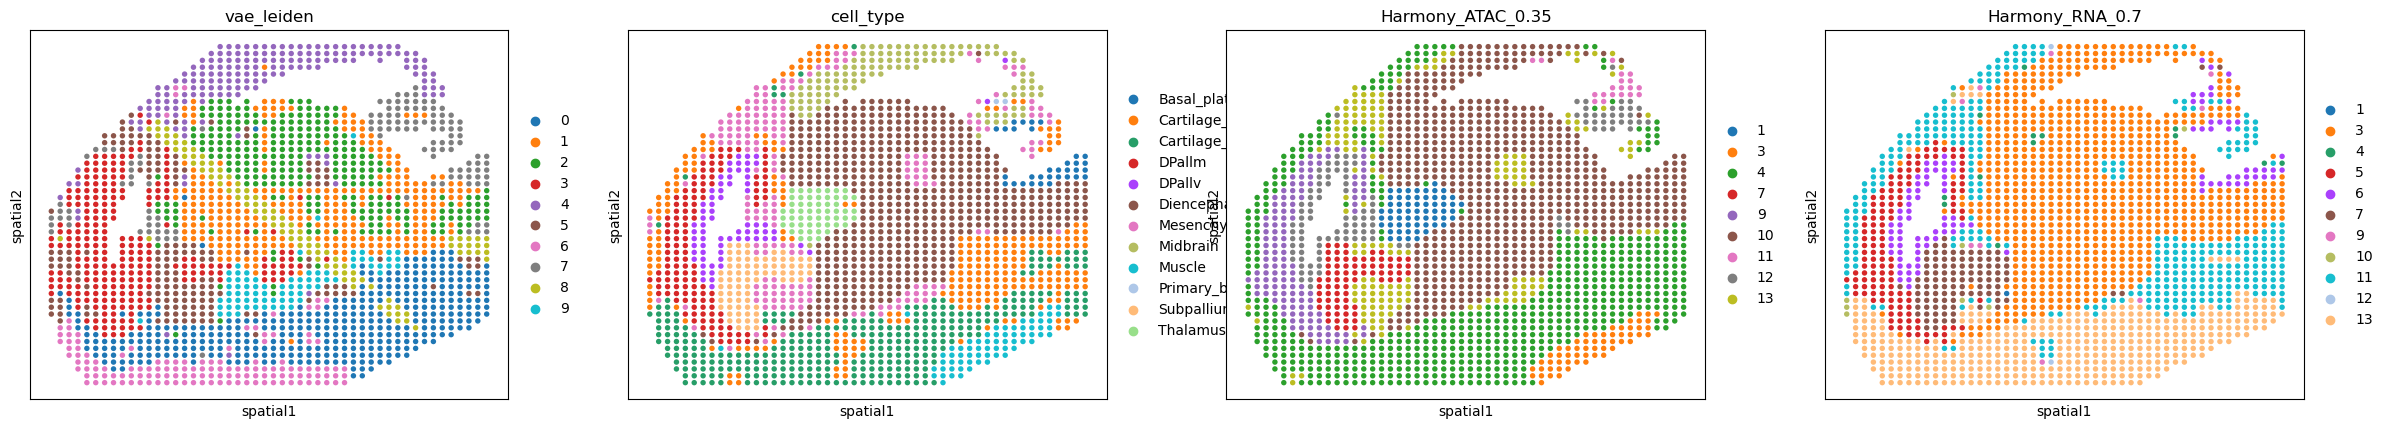

Reconstruction shape: (1949, 1294)


In [41]:

input_dim = S1_RNA_data.shape[1]

ENCODER_DIMS = [1024,512,256]
LATENT_DIM = 256
DECODER_DIMS = [256,512,1024]
RECON_LOSS_TYPE = "nb"
DROPOUT_RATE = 0.3

print("Building model...")
atac_vae_model = Spatial_VAE(
    input_dim=input_dim,
    encoder_dims=ENCODER_DIMS,
    latent_dim=LATENT_DIM,
    decoder_dims=DECODER_DIMS,
    reconstruction_loss=RECON_LOSS_TYPE,
    dropout_rate=DROPOUT_RATE,
).to(DEVICE)

print("Loading weights from:", WEIGHT_PATH)
state_dict = torch.load(WEIGHT_PATH, map_location=DEVICE)
atac_vae_model.load_state_dict(state_dict)
atac_vae_model.eval()

with torch.no_grad():
    X_vae = atac_vae_model.get_latent_representation(x_tensor, edge_index)

print("Latent shape:", X_vae.shape)
S1_RNA_data.obsm["X_vae"] = X_vae
S1_RNA_data.obs['Harmony_ATAC_0.35']=S1_RNA_data.obs['Harmony_ATAC_0.35'].astype('category')
S1_RNA_data.obs['Harmony_RNA_0.7']=S1_RNA_data.obs['Harmony_RNA_0.7'].astype('category')

sc.pp.neighbors(S1_RNA_data, use_rep="X_vae")
sc.tl.umap(S1_RNA_data)
sc.tl.leiden(S1_RNA_data, resolution=0.8,key_added='vae_leiden')

sc.pl.umap(S1_RNA_data, color=["vae_leiden",'cell_type','Harmony_ATAC_0.35','Harmony_RNA_0.7'])
sc.pl.embedding(S1_RNA_data, basis="spatial",color=["vae_leiden",'cell_type','Harmony_ATAC_0.35','Harmony_RNA_0.7'])

with torch.no_grad():
    out = atac_vae_model(x_tensor, edge_index, deterministic=True)

if RECON_LOSS_TYPE == "nb":
    recon = out["recon_mu"].cpu().numpy()
else:
    recon = torch.sigmoid(out["recon_logits"]).cpu().numpy()

print("Reconstruction shape:", recon.shape)



In [ ]:
S2_RNA_data = sc.read_h5ad("examples/A2R/RNA_VAE/S2_RNA_common.h5ad")
S2_RNA_data.obs['ATAC_Clusters']=S2_RNA_data.obs['ATAC_Clusters'].astype('category')
S2_RNA_data.obs['RNA_Clusters']=S2_RNA_data.obs['RNA_Clusters'].astype('category')
edge_index_s2 = build_spatial_graph(S2_RNA_data, n_neighbors=3,device=DEVICE)
x_tensor_s2= data_to_tensor(S2_RNA_data, DEVICE)

In [7]:
with torch.no_grad():
    X_vae = atac_vae_model.get_latent_representation(x_tensor_s2, edge_index_s2)

print("Latent shape:", X_vae.shape)
S2_RNA_data.obsm["X_vae"] = X_vae


Latent shape: (1939, 256)


# Diffusion


In [8]:
from SpaDiffusion.diffusion import *

In [29]:
# Redefine the repaired function
from scipy.stats import spearmanr, pearsonr
import numpy as np

def evaluate_and_visualize(sampled_atac, real_atac):
    """Evaluate the consistency between generated and real latent spaces"""
    # Convert to numpy arrays
    pred = sampled_atac.cpu().numpy()
    true = real_atac.cpu().numpy()
    
    print("="*60)
    print("Latent Space Evaluation Results")
    print("="*60)
    
    # Basic Statistics
    print(f"\n📊 Basic Statistics:")
    print(f"   True Values      - Mean: {true.mean():.4f}, Std: {true.std():.4f}")
    print(f"   Generated Values - Mean: {pred.mean():.4f}, Std: {pred.std():.4f}")
    
    
    # Global Level
    print(f"\n🌐 Global Level:")
    global_corr_p = pearsonr(true.flatten(), pred.flatten())[0]
    global_corr_s = spearmanr(true.flatten(), pred.flatten())[0]
    print(f"   Pearson:  {global_corr_p:.4f}")
    print(f"   Spearman: {global_corr_s:.4f}")
    
    print("="*60)
    return pred

In [10]:
import numpy as np
import scanpy as sc
from typing import Tuple

def align_anndata_objects(adata_atac: sc.AnnData, adata_rna: sc.AnnData) -> Tuple[sc.AnnData, sc.AnnData]:

    print("--- Starting AnnData object alignment ---")
    
    # 1. Find intersection of cell indices
    common_cells = adata_atac.obs.index.intersection(adata_rna.obs.index)
    
    print(f"Original ATAC data: {adata_atac.n_obs} cells")
    print(f"Original RNA data: {adata_rna.n_obs} cells")
    print(f"Found {len(common_cells)} common cells")
    
    # 2. Subset both AnnData objects to common cells
    # Use .copy() to avoid 'view vs. copy' issues in pandas/anndata
    atac_aligned = adata_atac[common_cells, :].copy()
    rna_aligned = adata_rna[common_cells, :].copy()
    
    # 3. Final verification to ensure consistency
    assert all(atac_aligned.obs.index == rna_aligned.obs.index)
    
    print(f"Alignment complete. Both datasets now contain {atac_aligned.n_obs} cells.")
    
    return atac_aligned, rna_aligned

def split_data_train_val(
    adata_atac: sc.AnnData,
    adata_rna: sc.AnnData,
    train_frac: float = 0.8,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray]:

    # 1. Consistency check: Ensure data is already aligned
    print("--- Verifying ATAC and RNA data alignment ---")
    assert all(adata_atac.obs.index == adata_rna.obs.index), \
        "Cell indices (obs.index) of ATAC and RNA data do not match."
    print("Data alignment verification successful.")

    # 2. Create indices and shuffle
    num_cells = adata_atac.shape[0]
    indices = np.arange(num_cells)
    
    # Use np.random.RandomState for seeded randomization
    rng = np.random.RandomState(random_state)
    rng.shuffle(indices)

    # 3. Calculate split point
    split_point = int(np.ceil(num_cells * train_frac))

    # 4. Partition indices
    train_ids = indices[:split_point]
    validation_ids = indices[split_point:]
    
    print(f"\n--- Data split complete ---")
    print(f"Total cells: {num_cells}")
    print(f"Training set: {len(train_ids)} cells ({train_frac*100:.1f}%)")
    print(f"Validation set: {len(validation_ids)} cells ({(1-train_frac)*100:.1f}%)")

    return train_ids, validation_ids

In [11]:

def get_params():
    return {
        'num_epoch': 500,# 2000
        'dropouts_rate': 0.2,
        'learning_rate': 0.001,
        'batch_size': 256,
        'num_heads': 8,
        'feature_dim': 256,
        'time_emb_dim': 256,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        'generation_times' : 100,
        'num_timesteps': 1000,  
        'cross_attn_dim': 256,

    }
visualize_steps = [0, 19,29,39,49,59,69,79,89, 99, 149, 199, 249, 299, 349, 399, 449, 499,549,599, 649, 699, 749, 799, 849, 899, 949, 999]

In [ ]:
S1_ATAC_data = sc.read_h5ad('examples/A2R/data/After_train_E15_5-S1_atac.h5ad')
S1_ATAC_data
S2_ATAC_data = sc.read_h5ad('examples/A2R/data/After_train_E15_5-S2_atac.h5ad')
S2_ATAC_data.obs['cell_type'] = S2_ATAC_data.obs['cell_type'].astype('category')

In [13]:
# Assuming S1_ATAC_data is your AnnData object
original_index = S1_ATAC_data.obs.index
print("Original first index:", original_index[0])

# Replace the specific suffix with an empty string
new_index = original_index.str.replace('_E15_5-S1', '')

# Assign the cleaned index back to the AnnData object
S1_ATAC_data.obs.index = new_index

print("Modified first index:", S1_ATAC_data.obs.index[0])

Original first index: GCCGCAACGCCGCAAC-1
Modified first index: GCCGCAACGCCGCAAC-1


In [14]:
# --- Step 1: Align data before splitting ---
# Using variables S1_ATAC_data and S1_RNA_data
S1_ATAC_aligned, S1_RNA_aligned = align_anndata_objects(S1_ATAC_data, S1_RNA_data)


# --- Step 2: Call the split function with aligned data ---
# The internal assertions will now pass successfully
train_ids, validation_ids = split_data_train_val(
    S1_ATAC_aligned,
    S1_RNA_aligned,
    train_frac=0.8,
    random_state=42
)

print("\nData splitting and index verification completed successfully.")

--- Starting AnnData object alignment ---
Original ATAC data: 1949 cells
Original RNA data: 1949 cells
Found 1949 common cells
Alignment complete. Both datasets now contain 1949 cells.
--- Verifying ATAC and RNA data alignment ---
Data alignment verification successful.

--- Data split complete ---
Total cells: 1949
Training set: 1560 cells (80.0%)
Validation set: 389 cells (20.0%)

Data splitting and index verification completed successfully.


In [15]:
x_rna_train = torch.tensor(S1_RNA_aligned[train_ids].obsm['X_vae'], dtype=torch.float32)
x_rna_valid = torch.tensor(S1_RNA_aligned[validation_ids].obsm['X_vae'], dtype=torch.float32)
x_atac_train = torch.tensor(S1_ATAC_aligned.obsm['AlignedEmbedding'][train_ids], dtype=torch.float32)
x_atac_valid = torch.tensor(S1_ATAC_aligned.obsm['AlignedEmbedding'][validation_ids], dtype=torch.float32)

In [16]:
setup_seed(42)
params = get_params()

# --- Prepare true count data for VAE loss ---
if sparse.issparse(S1_RNA_aligned.X):
    true_counts_train = S1_RNA_aligned.X[train_ids].toarray()
else:
    true_counts_train = S1_RNA_aligned.X[train_ids].copy()
true_counts_train = true_counts_train.astype(np.float32)

# Create Dataset and DataLoader
train_dataset = LatentDataset(x_rna_train, x_atac_train, true_counts=true_counts_train)
dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

# Initialize Diffusion Backbone
model = DiffusionBackbone(
    feature_dim=params['feature_dim'], 
    time_emb_dim=params['time_emb_dim'],
    num_heads=params['num_heads'],
    cross_attn_proj_dim=params['cross_attn_dim'],
    dropout=params['dropouts_rate']
).to(params['device'])

atac_vae_model = atac_vae_model.to(params['device'])

# Freeze Encoder and Unfreeze Decoder for joint training
for param in atac_vae_model.decoder.parameters():
    param.requires_grad = True

for param in atac_vae_model.encoder.parameters():
    param.requires_grad = False

# Initialize Noise Scheduler
noise_adder = add_latent_noise(num_timesteps=params['num_timesteps']).to(params['device'])

# Combine parameters for optimizer
trainable_params = list(model.parameters()) + list(atac_vae_model.decoder.parameters())
optimizer = optim.Adam(trainable_params, lr=params['learning_rate'])

print("="*60)
print("Starting Joint Training: Diffusion Model + VAE Decoder")
print("="*60)
print(f"Diffusion Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"VAE Decoder parameters:      {sum(p.numel() for p in atac_vae_model.decoder.parameters()):,}")
print(f"Total trainable parameters:  {sum(p.numel() for p in trainable_params):,}")
print("="*60)

# =============================================================================
# Model Training (Simultaneous Diffusion Loss and VAE Loss)
# =============================================================================
# Execute training function for both the diffusion model and VAE decoder
model = train_model_with_vae_loss(
    model=model,
    vae_model=atac_vae_model,
    dataloader=dataloader, 
    noise_adder=noise_adder, 
    optimizer=optimizer, 
    num_epochs=params['num_epoch'], 
    device=params['device'],
    lambda_cosine_latent=0,      # Set to 0 to disable cosine similarity loss
    lambda_vae=1.0,              # Weight for VAE loss, active after vae_start_epoch
    true_counts=true_counts_train, # Pass raw RNA counts for reconstruction
    edge_index=edge_index,       # Pass spatial graph (reserved interface)
    vae_start_epoch=200          # Join VAE training starting from epoch 200
)

Starting Joint Training: Diffusion Model + VAE Decoder
Diffusion Model parameters: 4,556,550
VAE Decoder parameters:      4,105,244
Total trainable parameters:  8,661,794


Total Progress:  40%|████      | 200/500 [12:00<19:12,  3.84s/epoch, Last_Loss=0.0938]


Phase switch: Starting from epoch 201, both Diffusion and VAE will be trained simultaneously



Total Progress: 100%|██████████| 500/500 [30:52<00:00,  3.71s/epoch, Last_Loss=0.4985]


In [ ]:
import os

# Set save directory
SAVE_DIR = "examples/A2R/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Save Diffusion Model
diffusion_model_path = os.path.join(SAVE_DIR, "diffusion_model_R2A_2000epochs.pt")
torch.save(model.state_dict(), diffusion_model_path)
print(f"✅ Diffusion model saved to: {diffusion_model_path}")
print(f"   Diffusion model parameter count: {sum(p.numel() for p in model.parameters()):,}")

# 2. Save Decoder Module
decoder_model_path = os.path.join(SAVE_DIR, "decoder_model_R2A_2000epochs.pt")
torch.save(atac_vae_model.decoder.state_dict(), decoder_model_path)
print(f"✅ Decoder model saved to: {decoder_model_path}")
print(f"   Decoder parameter count: {sum(p.numel() for p in atac_vae_model.decoder.parameters()):,}")

# 3. Optional: Save Full Checkpoint (Includes optimizer state, config, etc.)
checkpoint_path = os.path.join(SAVE_DIR, "full_checkpoint_R2A_2000epochs.pt")
checkpoint = {
    'diffusion_model_state_dict': model.state_dict(),
    'decoder_state_dict': atac_vae_model.decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_history': getattr(model, 'training_history', {}),
    'model_config': {
        'feature_dim': params['feature_dim'],
        'time_emb_dim': params['time_emb_dim'],
        'num_heads': params['num_heads'],
        'cross_attn_proj_dim': params['cross_attn_dim'],
        'dropout': params['dropouts_rate'],
    },
    'decoder_config': {
        'decoder_dims': DECODER_DIMS,
        'latent_dim': LATENT_DIM,
        'reconstruction_loss': RECON_LOSS_TYPE,
    }
}
torch.save(checkpoint, checkpoint_path)
print(f"✅ Full checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("Model saving process complete!")
print("="*60)

✅ Diffusion model saved to: /mnt/d/SpaDiffusion/examples/A2R/saved_models/diffusion_model_R2A_2000epochs.pt
   Diffusion model parameter count: 4,556,550
✅ Decoder model saved to: /mnt/d/SpaDiffusion/examples/A2R/saved_models/decoder_model_R2A_2000epochs.pt
   Decoder parameter count: 4,105,244
✅ Full checkpoint saved to: /mnt/d/SpaDiffusion/examples/A2R/saved_models/full_checkpoint_R2A_2000epochs.pt

Model saving process complete!


In [30]:
# --- Inference Mode ---
model.eval()

# Input: Validation set ATAC latent representation
x_atac_valid_device = x_atac_valid.to(params['device'])

# Sampling / Generation
# Note: Using DDIM sampling for accelerated inference
sampled_rna = ddim_sample(
    model=model,
    x_atac=x_atac_valid_device,
    noise_adder=noise_adder,
    num_steps=50,       # Only 50 steps required for DDIM
    eta=0.0,            # Fully deterministic sampling
    device=params['device'],
    clip_value=10.0,
    verbose=True
)

# Generation Statistics
print(f"\nGeneration Results Statistics:")
print(f"  Mean:               {sampled_rna.mean().item():.4f}")
print(f"  Standard Deviation: {sampled_rna.std().item():.4f}")
print(f"  Range:              [{sampled_rna.min().item():.4f}, {sampled_rna.max().item():.4f}]")

# Evaluation
print("\nEvaluating Latent Space Correlation:")
evaluate_and_visualize(sampled_rna, x_rna_valid.to(params['device']))

Starting DDIM sampling (steps=50, eta=0.0)...
Step 1/50: Mean=0.0039, Std=0.9986, Range=[-4.3533, 4.3458]
Step 10/50: Mean=0.0058, Std=0.9989, Range=[-4.3096, 4.2885]
Step 20/50: Mean=0.0096, Std=1.0100, Range=[-4.2444, 4.3263]
Step 30/50: Mean=0.0173, Std=1.0496, Range=[-4.1622, 4.5370]
Step 40/50: Mean=0.0246, Std=1.0614, Range=[-4.1605, 4.2506]
Step 50/50: Mean=0.0277, Std=1.0406, Range=[-4.4081, 4.1146]
DDIM sampling completed!

Generation Results Statistics:
  Mean:               0.0277
  Standard Deviation: 1.0406
  Range:              [-4.4081, 4.1146]

Evaluating Latent Space Correlation:
Latent Space Evaluation Results

📊 Basic Statistics:
   True Values      - Mean: 0.0027, Std: 1.0414
   Generated Values - Mean: 0.0277, Std: 1.0406

🌐 Global Level:
   Pearson:  0.5382
   Spearman: 0.5329


array([[ 1.5432868 ,  0.27077547,  1.3739127 , ..., -0.1957126 ,
         0.5340053 , -0.24569057],
       [-0.2048477 , -1.3737444 ,  0.07739109, ..., -2.045166  ,
        -1.3817078 , -0.0232008 ],
       [ 1.0408784 , -0.880917  ,  0.09591345, ..., -0.48609653,
        -0.47612143, -0.18492398],
       ...,
       [ 0.7156495 , -1.8354126 , -0.88623345, ..., -1.0597291 ,
        -1.0382375 ,  0.69995147],
       [-0.18548587, -1.9348924 , -1.1035475 , ..., -0.6711599 ,
        -0.27679768, -0.80505884],
       [ 0.62577677, -2.0253859 , -1.831685  , ..., -0.21074736,
        -1.7253577 , -1.0619402 ]], dtype=float32)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from scipy import sparse
import numpy as np
import torch
import scanpy as sc

def evaluate_end_to_end(
    vae_model: torch.nn.Module,
    generated_latent_rna: torch.Tensor,
    adata_true_full: sc.AnnData,
    validation_ids: np.ndarray
):

    print("\n" + "=" * 50)
    print("--- Starting End-to-End Comprehensive Evaluation ---")
    print("=" * 50)

    # 1. Preparation
    vae_model.eval()
    device = next(vae_model.parameters()).device
    z = generated_latent_rna.to(device)

    # Extract ground truth counts for the validation set
    adata_true_validation = adata_true_full[validation_ids, :]
    if sparse.issparse(adata_true_validation.X):
        true_counts_np = adata_true_validation.X.toarray()
    else:
        true_counts_np = adata_true_validation.X

    # 2. Decoding: Map latent space z back to expected count values (NB decoding logic)
    with torch.no_grad():
        decoder_output = vae_model.decoder(z)
        if getattr(vae_model, "reconstruction_loss", "nb") == "nb":
            # Split output into mean (mu) and dispersion (theta) parameters
            recon_mu_log, recon_theta_log = torch.chunk(decoder_output, 2, dim=-1)
            reconstructed_counts_np = torch.exp(recon_mu_log).cpu().numpy()
        else:
            # Fallback for MSE/BCE logic
            reconstructed_counts_np = torch.sigmoid(decoder_output).cpu().numpy()

    # Verify matrix dimensions
    if reconstructed_counts_np.shape != true_counts_np.shape:
        print(f"Warning: Reconstructed matrix shape {reconstructed_counts_np.shape} "
              f"mismatches true matrix shape {true_counts_np.shape}. Check input/model config.")

    print(f"Successfully decoded latent representations for {z.shape[0]} cells into a count matrix.")
    print(f"Matrix Dimensions: {reconstructed_counts_np.shape}")

    # 3. Multi-level Evaluation
    # --- 1) Matrix-level ---
    print("\n--- [Matrix-level] Correlation Evaluation (Generated vs. True) ---")
    true_flat = true_counts_np.flatten()
    recon_flat = reconstructed_counts_np.flatten()

    pearson_corr, pearson_p = pearsonr(true_flat, recon_flat)
    spearman_corr, spearman_p = spearmanr(true_flat, recon_flat)

    print(f"Overall Pearson Correlation:  {pearson_corr:.4f} (P-value: {pearson_p:.4e})")
    print(f"Overall Spearman Correlation: {spearman_corr:.4f} (P-value: {spearman_p:.4e})")


    print("\n--- [Cell-level] Correlation Evaluation (Generated vs. True) ---")
    cell_corrs = []
    for i in range(true_counts_np.shape[0]):
        true_cell = true_counts_np[i, :]
        recon_cell = reconstructed_counts_np[i, :]
        if np.std(true_cell) > 1e-6 and np.std(recon_cell) > 1e-6:
            cell_corrs.append(pearsonr(true_cell, recon_cell)[0])

    if cell_corrs:
        print(pd.Series(cell_corrs).describe())
    else:
        print("Could not calculate Cell-level correlations (check variance).")

    print("\n" + "=" * 50)

    return reconstructed_counts_np, cell_corrs

In [32]:

atac_vae_model.eval()

final_reconstructed_counts,  cell_correlations = evaluate_end_to_end(
    vae_model=atac_vae_model,
    generated_latent_rna=sampled_rna,
    adata_true_full=S1_RNA_aligned, 
    validation_ids=validation_ids
)


--- Starting End-to-End Comprehensive Evaluation ---
Successfully decoded latent representations for 389 cells into a count matrix.
Matrix Dimensions: (389, 1294)

--- [Matrix-level] Correlation Evaluation (Generated vs. True) ---
Overall Pearson Correlation:  0.7323 (P-value: 0.0000e+00)
Overall Spearman Correlation: 0.4209 (P-value: 0.0000e+00)

--- [Cell-level] Correlation Evaluation (Generated vs. True) ---
count    389.000000
mean       0.955975
std        0.032920
min        0.653295
25%        0.947709
50%        0.963504
75%        0.973981
max        0.994043
dtype: float64



In [33]:
# =============================================================================
#
#                          S2 Data Evaluation Workflow
#
#   Core Principle: Perform inference on the S2 dataset using the model 
#   trained on S1 to test the model's generalization capabilities.
#
# =============================================================================

print("Starting end-to-end evaluation for the S2 dataset...")

# --- Step 1: Data Preprocessing and Alignment ---
print("\n--- Step 1: Preprocessing and aligning S2 data ---")

# (Optional) Clean S2 ATAC cell indices to ensure they match RNA data
# Assuming S2 ATAC data indices have the suffix '_E15_5-S2'
if S2_RNA_data.obs.index[0].endswith('_E15_5-S2'):
    print("Detected and cleaning suffix from S2 ATAC indices...")
    s2_new_index = S2_RNA_data.obs.index.str.replace('_E15_5-S2', '')
    S2_RNA_data.obs.index = s2_new_index

# Align S2 ATAC and RNA objects
S2_ATAC_aligned, S2_RNA_aligned = align_anndata_objects(S2_ATAC_data, S2_RNA_data)

# Compute spatial adjacency graph for S2 data, required by the VAE encoder
print("Computing spatial adjacency graph for S2 data...")
s2_edge_index = build_spatial_graph(S2_RNA_data, n_neighbors=3, device=DEVICE)
s2_full_tensor = data_to_tensor(S2_RNA_data, DEVICE)

# Ensure data consists of integer counts
if not isinstance(S2_RNA_aligned.X, sparse.csr_matrix):
    S2_RNA_aligned.X = sparse.csr_matrix(S2_RNA_aligned.X)
S2_RNA_aligned.X.data = S2_RNA_aligned.X.data.astype(np.int32)


# --- Step 2: Extract Ground Truth Latent Representation using VAE Encoder ---
print("\n--- Step 2: Generating ground truth RNA latent representation for S2 via VAE encoder ---")
atac_vae_model.eval()  # Set VAE to evaluation mode
device = next(atac_vae_model.parameters()).device

# Extract latent representation
with torch.no_grad():
    s2_true_rna_latent = atac_vae_model.get_latent_representation(s2_full_tensor, s2_edge_index)
    S2_RNA_aligned.obsm['X_vae'] = s2_true_rna_latent
print("Ground truth S2 RNA latent representation generated and stored in .obsm['X_vae']")


# --- Step 3: Generate Predicted RNA Latent Representation via Diffusion Model ---
print("\n--- Step 3: Generating predicted RNA latent representation from S2 ATAC using Diffusion model ---")
model.eval()  # Set diffusion model to evaluation mode

# Extract S2 ATAC embeddings to use as the condition
x_s2_atac_latent = torch.tensor(S2_ATAC_aligned.obsm['AlignedEmbedding'], dtype=torch.float32).to(device)

# Execute DDIM sampling process
with torch.no_grad():
    sampled_s2_rna_latent = ddim_sample(
        model,
        x_s2_atac_latent,
        noise_adder,
        num_steps=50,
        device=device
    )
print("Predicted S2 RNA latent representation generated successfully.")

print("\n--- Step 4: Evaluating latent space consistency (Ground Truth RNA vs. Predicted RNA) ---")
evaluate_and_visualize(sampled_s2_rna_latent, torch.tensor(s2_true_rna_latent))

Starting end-to-end evaluation for the S2 dataset...

--- Step 1: Preprocessing and aligning S2 data ---
--- Starting AnnData object alignment ---
Original ATAC data: 1939 cells
Original RNA data: 1939 cells
Found 1939 common cells
Alignment complete. Both datasets now contain 1939 cells.
Computing spatial adjacency graph for S2 data...

--- Step 2: Generating ground truth RNA latent representation for S2 via VAE encoder ---
Ground truth S2 RNA latent representation generated and stored in .obsm['X_vae']

--- Step 3: Generating predicted RNA latent representation from S2 ATAC using Diffusion model ---
Starting DDIM sampling (steps=50, eta=0.0)...
Step 1/50: Mean=0.0004, Std=0.9993, Range=[-4.8204, 5.1448]
Step 10/50: Mean=0.0023, Std=0.9995, Range=[-4.7612, 5.1935]
Step 20/50: Mean=0.0060, Std=1.0108, Range=[-4.6811, 5.2663]
Step 30/50: Mean=0.0135, Std=1.0501, Range=[-4.7197, 5.2537]
Step 40/50: Mean=0.0214, Std=1.0604, Range=[-4.8297, 5.0925]
Step 50/50: Mean=0.0252, Std=1.0370, Rang

array([[ 0.08299202, -0.8909405 , -0.00589529, ...,  0.53009045,
        -0.6834556 , -0.82321936],
       [-0.44065747, -1.1058359 , -0.68064374, ..., -1.9014072 ,
        -1.1435376 ,  0.2753318 ],
       [ 1.8373989 ,  0.04905022,  1.2390801 , ...,  0.0624739 ,
        -0.77323437, -0.89625794],
       ...,
       [ 0.20553552,  0.3173079 ,  1.8625778 , ..., -0.40994212,
        -0.28828216, -0.35997903],
       [-0.24468617, -0.15781076,  0.01913726, ..., -0.3217941 ,
        -0.02206614,  1.031615  ],
       [ 1.6183165 , -0.28703457,  1.1512744 , ..., -0.8872151 ,
         0.15948562,  0.65795755]], dtype=float32)

In [35]:
# --- Step 5: Execute End-to-End Comprehensive Evaluation ---
print("\n--- Step 5: Performing end-to-end comprehensive evaluation (Decoding to count space) ---")

# Using the final version of the evaluation function, covering all three levels of assessment
final_reconstructed_counts_s2,  cell_correlations_s2 = evaluate_end_to_end(
    vae_model=atac_vae_model,
    generated_latent_rna=sampled_s2_rna_latent,
    adata_true_full=S2_RNA_aligned,
    validation_ids=np.arange(S2_RNA_aligned.n_obs) # Evaluating across the entire S2 dataset
)


--- Step 5: Performing end-to-end comprehensive evaluation (Decoding to count space) ---

--- Starting End-to-End Comprehensive Evaluation ---
Successfully decoded latent representations for 1939 cells into a count matrix.
Matrix Dimensions: (1939, 1294)

--- [Matrix-level] Correlation Evaluation (Generated vs. True) ---
Overall Pearson Correlation:  0.7630 (P-value: 0.0000e+00)
Overall Spearman Correlation: 0.4218 (P-value: 0.0000e+00)

--- [Cell-level] Correlation Evaluation (Generated vs. True) ---
count    1939.000000
mean        0.925242
std         0.074958
min         0.172876
25%         0.911538
50%         0.942502
75%         0.962670
max         0.991133
dtype: float64



In [ ]:

A2R_predict=ad.AnnData(final_reconstructed_counts_s2,obs=S2_ATAC_data.obs,var=S1_RNA_data.var,obsm=S2_ATAC_data.obsm).copy()
A2R_predict.write_h5ad('/examples/A2R/Predicted_E15_5-S2_A2R_expr_spadiffusion_decoder_2000.h5ad')